In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

sys.path.append(os.path.abspath(".."))
from dataset.phc_dataset import PhC2DBandgapQuickLoad
from model_architecture import RegressionAnalyticBNN

from scipy.stats import spearmanr

/state/partition1/llgrid/pkg/anaconda/anaconda3-2022b/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [3]:
test_dataset = PhC2DBandgapQuickLoad(train=False)

inputs = test_dataset[:][0].to(device)
targets = test_dataset[:][1]

saved_data_path = 'experiment_results/random_vs_uncertain_vs_error'

In [ ]:
def create_bins(start, end, spacing):
    bin_edges = np.arange(start, end + spacing, spacing)
    if bin_edges[-1] > end:
        bin_edges[-1] = end
    bins = np.vstack((bin_edges[:-1], bin_edges[1:])).T
    return bins

def plot_analytic_correlation(model_path, inputs, targets, graph=True, save_fig=False):
    model = RegressionAnalyticBNN().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device)['state_dict'])
    with torch.no_grad():
        predictions_mean, _, outputs_variance = model(inputs)

    outputs_variance = outputs_variance.cpu()
    predictions_mean = predictions_mean.cpu()
    
    uncertain_indices = torch.argsort(-1*outputs_variance)

    start_value = 0
    final_value = len(inputs)
    spacing = 100
    bins = create_bins(start_value, final_value, spacing)
    bin_losses = []

    for (lower, upper) in bins:
        relevant_targets = targets[uncertain_indices[lower:upper]]
        relevant_predictions = predictions_mean[uncertain_indices[lower:upper]]
        bin_mse_loss = F.mse_loss(relevant_predictions, relevant_targets)
        bin_losses.append(bin_mse_loss.item())
    spearman_coeff = spearmanr(bins[:,0], bin_losses).correlation
    if graph:
        plt.bar(bins[:,1], bin_losses, width=spacing, color='#56B4E9', edgecolor='black', label=f'Spearman Coefficient = {spearman_coeff}')
        plt.xlabel('Samples sorted by uncertainty', fontsize=14)
        plt.ylabel(f'MSE', fontsize=14)
        plt.title(f'Uncertainty and Accuracy Correlation', fontsize=14)
        plt.legend()
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        if save_fig:
            plt.savefig(os.path.join("images", "correlation_example.pdf"), bbox_inches='tight')
        plt.show()
    return spearman_coeff

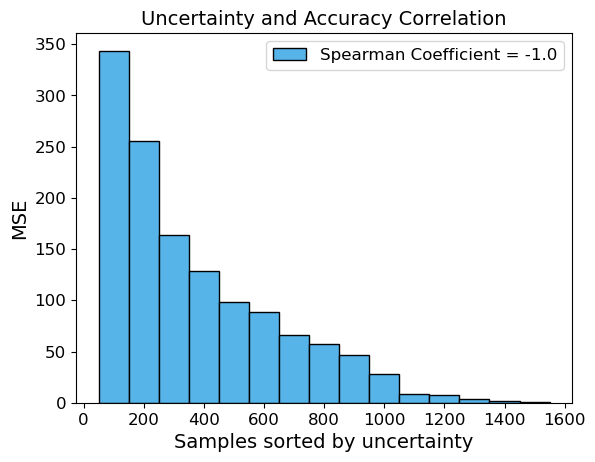

In [5]:
for index in [0]:
    model_path = os.path.join(saved_data_path, f'random_0', f'active_iterations_{index}', 'epoch_300_checkpoint.pth.tar')
    plot_analytic_correlation(model_path, inputs, targets, graph=True, save_fig=True)

In [ ]:
def aggregate_and_plot_all(data_folder, num_seeds, active_batch_size, initial_train_size, save_fig=False,ylim=None, scale_log=False):
    """
    Loads accuracy runs, aggregates mean/std for uncertain vs random vs error,
    and plots mean with SEM bands.
    """
    run_histories, run_means, run_std = {}, {}, {}
    experiments = ['uncertain', 'random', 'error']
    experiment_names = ['Analytic LL-BNN', 'Random', 'Oracle Sampling (Unavailable)']
    for param in experiments:
        run_histories[param] = [np.load(os.path.join(data_folder, f"{param}_{seed_idx}", "accuracy.npy")) for seed_idx in range(num_seeds)]
        run_histories[param] = np.array(run_histories[param])
        run_means[param] = np.mean(run_histories[param], axis=0)
        run_std[param] = np.std(run_histories[param], axis=0)

    # Print quick stats
    print("Initial accuracies:")
    for param in experiments:
        print(f'{param}: {run_means[param][0]}')

    # X-axis
    num_active_iterations = len(run_histories['uncertain'][0])
    sample_counts = initial_train_size + np.arange(num_active_iterations) * active_batch_size

    plt.figure()
    colors = ["#E69F00", "#56B4E9", "#009E73"]
    for param, name, color in zip(experiments, experiment_names, colors):
        plt.errorbar(sample_counts, run_means[param], run_std[param] / np.sqrt(num_seeds), label=name, color=color)
    plt.title("Error over Active Learning Iterations", fontsize=14)
    plt.xlabel("Number of Training Samples", fontsize=14)
    plt.ylabel("MSE", fontsize=14)
    if ylim: plt.ylim(*ylim)
    if scale_log:
        plt.yscale('log')
    plt.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(os.path.join("images", "error_over_active_learning_iterations.pdf"), bbox_inches='tight')
    plt.show()
    return run_means

def get_spearman_coeffs(data_folder, num_seeds, num_active_iterations):
    sc_histories, sc_means, sc_std = {}, {}, {}
    experiments = ['uncertain', 'random', 'error']
    for param in experiments:
        sc_histories[param] = []
        for seed_idx in range(num_seeds):
            print(f'Starting {param}_{seed_idx}')
            temp_sc_histories = []
            for iteration in range(num_active_iterations):
                model_path = os.path.join(data_folder, f'{param}_{seed_idx}',
                                        f'active_iterations_{iteration}', 'epoch_300_checkpoint.pth.tar')
                temp_sc_histories.append(plot_analytic_correlation(model_path, inputs, targets, graph=False))
            sc_histories[param].append(np.array(temp_sc_histories))
        sc_histories[param] = np.array(sc_histories[param])
        sc_means[param] = np.mean(sc_histories[param], axis=0)
        sc_std[param] = np.std(sc_histories[param], axis=0)

    return sc_means, sc_std

def plot_spearman_coeffs(sc_means, sc_std, num_seeds, active_batch_size, initial_train_size, num_active_iterations, save_fig=False,
                        ylim=None, scale_log=False):
    experiments = ['uncertain', 'random'] #, 'error']
    experiment_names = ['Analytic LL-BNN', 'Random'] #, 'True Error']

    # X-axis
    sample_counts = initial_train_size + np.arange(num_active_iterations) * active_batch_size

    plt.figure()
    colors = ["#E69F00", "#56B4E9"] #, "#009E73"]
    for param, name, color in zip(experiments, experiment_names, colors):
        plt.errorbar(sample_counts, sc_means[param], sc_std[param] / np.sqrt(num_seeds), label=name, color=color)
    plt.title("Correlation over Active Learning Iterations", fontsize=14)
    plt.xlabel("Number of Training Samples", fontsize=14)
    plt.ylabel("Spearman Coefficient", fontsize=14)
    if ylim: plt.ylim(*ylim)
    if scale_log:
        plt.yscale('log')
    plt.legend()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    if save_fig:
        plt.savefig(os.path.join("images", "correlation_over_active_learning_iterations.pdf"), bbox_inches='tight')
    plt.show()

Initial accuracies:
uncertain: 53.966915130615234
random: 53.91896781921387
error: 53.892144775390626


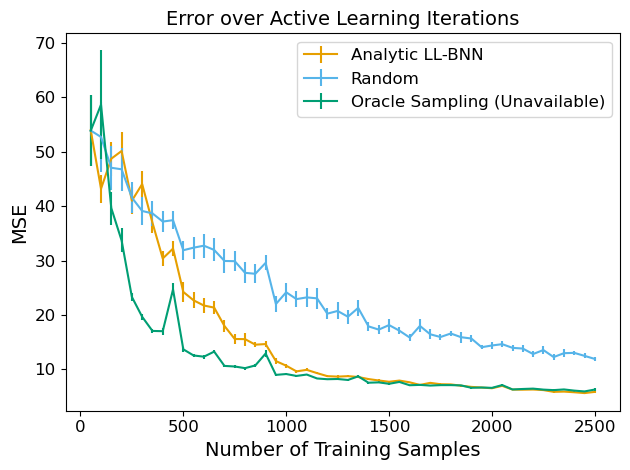

In [10]:
run_means = aggregate_and_plot_all(saved_data_path, 10, 50, 50, save_fig=True)

In [8]:
sc_means, sc_std = get_spearman_coeffs(saved_data_path, 10, 50)

Starting uncertain_0
Starting uncertain_1
Starting uncertain_2
Starting uncertain_3
Starting uncertain_4
Starting uncertain_5
Starting uncertain_6
Starting uncertain_7
Starting uncertain_8
Starting uncertain_9
Starting random_0
Starting random_1
Starting random_2
Starting random_3
Starting random_4
Starting random_5
Starting random_6
Starting random_7
Starting random_8
Starting random_9
Starting error_0
Starting error_1
Starting error_2
Starting error_3
Starting error_4
Starting error_5
Starting error_6
Starting error_7
Starting error_8
Starting error_9


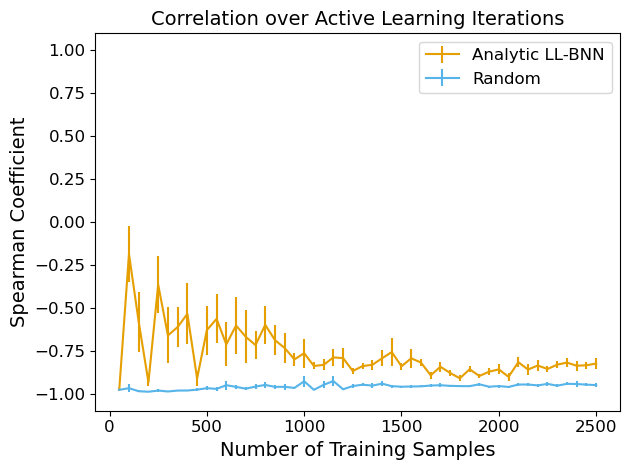

In [9]:
plot_spearman_coeffs(sc_means, sc_std, 10, 50, 50, 50, save_fig=True, ylim=(-1.1, 1.1))